In [3]:
from linescanning import *
from linescanning import transform
import os
import nibabel as nb
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import pathlib

opj = os.path.join
base, place = utils.get_base_dir()

proj = opj(base, 'projects', 'hemifield')
prog = opj(base, 'programs', 'linescanning')

In [12]:
# warp session 1 files to slice resolution via session 1 to session 2 warp file (only 1 interpolation!)
subj = ['001','003','004','005','006']
subj = ['003']
from_ses = 1
to_ses = 3

for ii in subj:

    print(f"\n----------------------- sub-{ii} -----------------------")

    subject = f'sub-{ii}'
    outdir = opj(proj, 'derivatives', 'nighres', subject, f'ses-{to_ses}') 
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    cortex = opj(proj, 'derivatives', 'pycortex', subject)
    masks = opj(proj, 'derivatives', 'manual_masks', subject, 'ses-1')

    #####################################################################################################################################
    # FETCH FILES

    # Fetch PVE/layers/depth files from session 1
    try:
        tissue_f = utils.get_file_from_substring("cortex.nii.gz", opj(outdir.replace(f'ses-{to_ses}', f'ses-{from_ses}'), 'cruise'))
        layers_f = utils.get_file_from_substring("layers.nii.gz", opj(outdir.replace(f'ses-{to_ses}', f'ses-{from_ses}'), 'layering'))
        depth_f  = utils.get_file_from_substring("depth.nii.gz", opj(outdir.replace(f'ses-{to_ses}', f'ses-{from_ses}'), 'layering'))
    except:
        raise FileNotFoundError("could not find layer and/or tissue image")
        
    tissue_img  = nb.load(tissue_f)
    layers_img  = nb.load(layers_f)
    depth_img = nb.load(depth_f)

    # Fetch wm/gm/csf probability files from session 1
    try:
        wm_f  = utils.get_file_from_substring("label-WM", masks)
        gm_f  = utils.get_file_from_substring("label-GM", masks)
        csf_f = utils.get_file_from_substring("label-CSF", masks)
        mask  = utils.get_file_from_substring("spm_mask", masks)
    except:
        raise FileNotFoundError("could not find tissue probability images")
        
    wm_img  = nb.load(wm_f)
    gm_img  = nb.load(gm_f)
    csf_img = nb.load(csf_f)

    #####################################################################################################################################
    # RESAMPLE TO SLICE

    try:
        slc = utils.get_file_from_substring("1slice_run-1_T1w.nii.gz", opj(proj, subject, f'ses-{to_ses}', 'anat'))
    except:
        raise FileNotFoundError(f"could not find slice-file in {opj(proj, subject, f'ses-{to_ses}', 'anat')}")
        
    try:
        warp_file = utils.get_file_from_substring(f"from-ses{from_ses}_to-ses{to_ses}", opj(cortex, 'transforms'))
    except:
        try:
            os.system(f"call_ses1_to_ses {subject} {to_ses}")
            warp_file = utils.get_file_from_substring(f"from-ses{from_ses}_to-ses{to_ses}", opj(cortex, 'transforms'))
        except:
            raise FileNotFoundError(f"could not find warp-file in {opj(os.environ['CTX'], 'transforms')}")

    # collect them in 'resampled' dictionary (in brackets is file suffixes)
    #  0 = wm prob  ("cruise-pwm")
    #  1 = gm prob  ("cruise-pgm")
    #  2 = csf prob ("cruise-pcsf")
    #  3 = pve      ("cruise-cortex")
    #  4 = layers   ("layering-layers")
    #  5 = depth    ("layering-depth")

    in_type = ['prob', 'prob', 'prob', 'tissue', 'layer', 'prob', 'tissue']
    tag = ['wm', 'gm', 'csf', 'cortex', 'layers', 'depth', 'mask']
    resampled = {}
    for n,f in enumerate([wm_f, gm_f, csf_f, tissue_f, layers_f, depth_f, mask]):
        
        # fn_parts = f.split(os.sep)[-1].split('_')
        # idx_acq = [(i, fn_parts.index('acq-')) for i, fn_parts in enumerate(fn_parts) if 'acq-' in fn_parts][0][0]
        # fn_parts[idx_acq] = 'acq-1slice' # replace acquisition with '1slice'

        # replace acq-MP2RAGE with acq-1slice
        new_fn = utils.replace_string(f,"acq-MP2RAGE", "acq-1slice")
        new_file = opj(outdir, os.path.basename(new_fn))
        
        if not os.path.exists(new_file):
            print('warping {} to slice (= line space)'.format(os.path.basename(f)))
            if in_type[n] == "tissue":
                # Use MultiLabel-interpolation for tissue-segmentation
                transform.ants_applytrafo(slc, f, interp="mul", trafo=warp_file, output=new_file)
            elif in_type[n] == "layer":
                # Use GenericLabel-interpolation for layer-segmentation
                transform.ants_applytrafo(slc, f, interp="gen", trafo=warp_file, output=new_file)
            else:
                # Use nearest neighbor-interpolation for probability maps
                transform.ants_applytrafo(slc, f, trafo=warp_file, output=new_file)
            
        else:
            print('{} already exists'.format(os.path.basename(new_file)))
            
        resampled[tag[n]] = new_file

    #####################################################################################################################################
    # SAVE IN PICKLE FILE

    f = open(opj(outdir, f'{subject}_space-ses{to_ses}_desc-segmentations.pkl'), "wb")
    pickle.dump(resampled, f)
    f.close()


----------------------- sub-003 -----------------------
warping sub-003_ses-1_acq-MP2RAGE_label-WM_probseg.nii.gz to slice (= line space)
call_antsapplytransforms -i "0" -t nn /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-1_T1w.nii.gz /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/manual_masks/sub-003/ses-1/sub-003_ses-1_acq-MP2RAGE_label-WM_probseg.nii.gz /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/nighres/sub-003/ses-3/sub-003_ses-1_acq-1slice_label-WM_probseg.nii.gz "/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-ses1_to-ses3_desc-genaff.mat"
warping sub-003_ses-1_acq-MP2RAGE_label-GM_probseg.nii.gz to slice (= line space)
call_antsapplytransforms -i "0" -t nn /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-1_T1w.nii.gz /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/m

In [11]:
os.system(f"call_ses1_to_ses {subject} {to_ses}")

0

In [3]:
df = {}
for ii in subj:

    print(f"Dealing with sub-{ii}")

    seg_file = utils.get_file_from_substring("segmentations",opj(proj,'derivatives','nighres',f'sub-{ii}','ses-2'))
    with open(seg_file, 'rb') as pf:
        data = pickle.load(pf)

    df[f'sub-{ii}'] = data
    df[f'sub-{ii}']['ref'] = utils.get_file_from_substring("1slice_run-1_T1w.nii.gz", opj(proj, f'sub-{ii}', 'ses-2', 'anat'))
    df[f'sub-{ii}']['line'] = image.create_line_from_slice(df[f'sub-{ii}']['ref'])

Dealing with sub-001
Dealing with sub-003
Dealing with sub-004
Dealing with sub-005
Dealing with sub-006


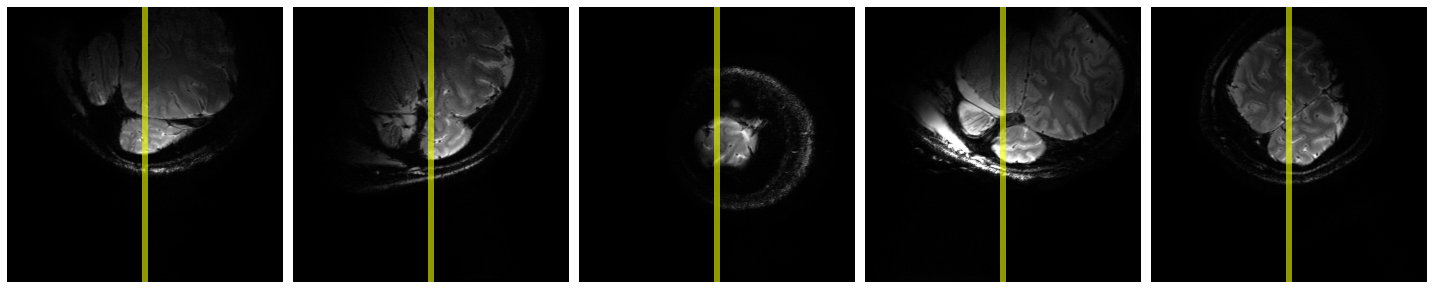

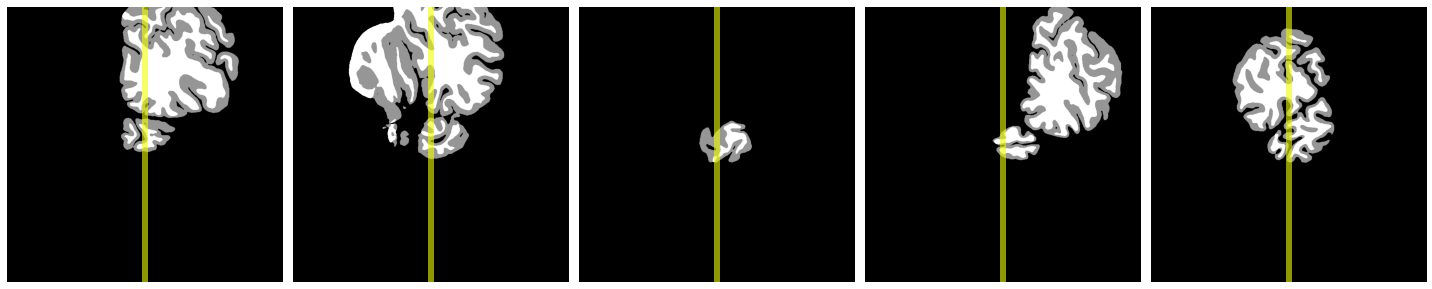

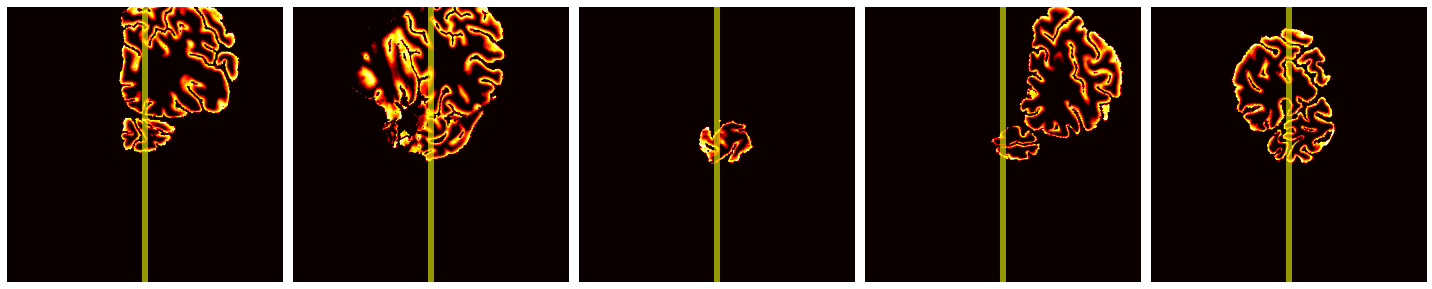

In [4]:
xx = 20
yy = 5

fig = plt.figure(figsize=(xx,yy))
axes = []
rows = 1
cols = len(df)

beam_cmap = utils.make_binary_cm(240,255,0)

for a in range(rows*cols):
    b = df[list(df.keys())[a]]

    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(np.clip(np.squeeze(nb.load(b['ref']).get_fdata()),0,5000), cmap='Greys_r')
    plt.imshow(np.squeeze(b['line'].get_fdata()), cmap=beam_cmap, alpha=0.6)
    axes[-1].axis('off')

fig.tight_layout()
fig.savefig(opj(proj, 'code', 'figures', 'seg2line_1.png'))

fig = plt.figure(figsize=(xx,yy))
axes = []
rows = 1
cols = len(df)

for a in range(rows*cols):
    b = df[list(df.keys())[a]]

    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(np.squeeze(nb.load(b['cortex']).get_fdata()), cmap='Greys_r')
    plt.imshow(np.squeeze(b['line'].get_fdata()), cmap=beam_cmap, alpha=0.6)
    axes[-1].axis('off')

fig.tight_layout()
fig.savefig(opj(proj, 'code', 'figures', 'seg2line_2.png'))

fig = plt.figure(figsize=(xx,yy))
axes = []
rows = 1
cols = len(df)

for a in range(rows*cols):
    b = df[list(df.keys())[a]]

    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(np.squeeze(nb.load(b['layers']).get_fdata()), cmap='hot')
    plt.imshow(np.squeeze(b['line'].get_fdata()), cmap=beam_cmap, alpha=0.6)
    axes[-1].axis('off')

fig.tight_layout()
fig.savefig(opj(proj, 'code', 'figures', 'seg2line_3.png'))


In [5]:
# fig = plt.figure(figsize=(20,20))
# axes = []
# rows = 1
# cols = len(df)

# for a in range(rows*cols):
#     b = df[list(df.keys())[a]]

#     axes.append(fig.add_subplot(rows,cols,a+1))
#     plt.imshow(np.squeeze(nb.load(b['cortex']).get_fdata()))
#     axes[-1].axis('off')

# fig.tight_layout()
# plt.show()

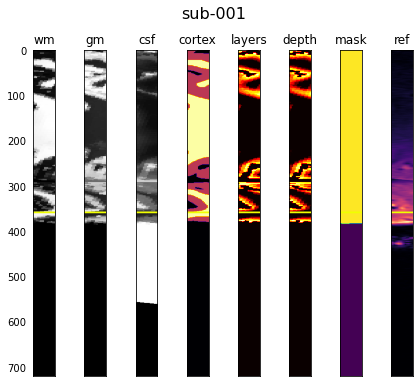

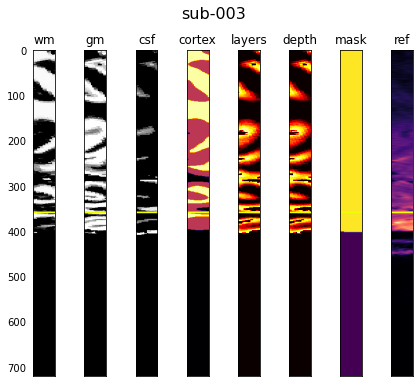

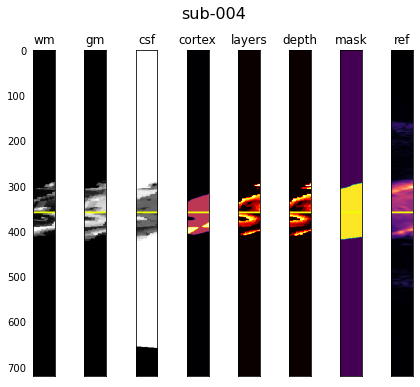

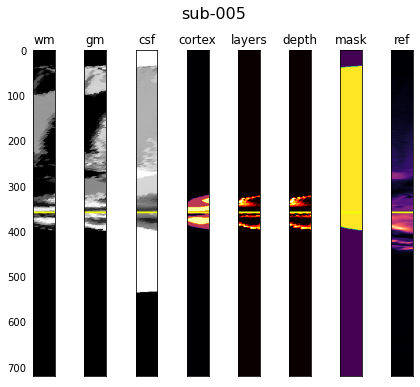

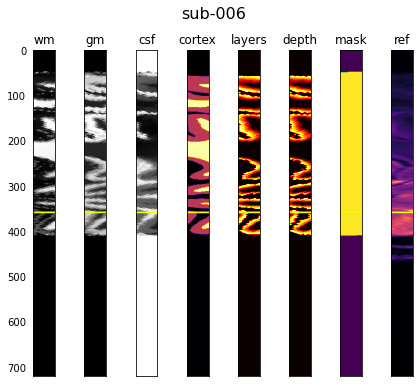

In [8]:
# https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot

for ii in ['sub-001','sub-003','sub-004','sub-005','sub-006']:
    ll = df[ii].copy()

    beam = {}
    for i in ll:

        # print(i)
        
        if isinstance(ll[i],str):
            img = nb.load(ll[i])
        elif isinstance(i,nb.Nifti1Image):
            img = i

        if len(img.get_fdata().shape) == 4:
            img_d = np.squeeze(img.get_fdata(), axis=3)
        else:
            img_d = img.get_fdata()

        beam[i] = np.squeeze(np.multiply(img_d,ll['line'].get_fdata().astype(bool))[:,352:368]) # fetch middle 16 voxels and remove 3rd axis

    # https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
    fig, axs = plt.subplots(1,len(beam)-1, figsize=(11, 6), facecolor='w', edgecolor='k', sharey=True)
    fig.subplots_adjust(hspace=.5, wspace=-0.8)

    fig.suptitle(ii, fontsize=16)
    axs = axs.ravel()

    cmaps = ['Greys_r','Greys_r','Greys_r','inferno','hot','hot', 'viridis', 'magma']

    for i,r in enumerate(beam):
        if r == "line":
            pass
        else:
            axs[i].set_title(r)
            axs[i].imshow(beam[r], aspect=1/3, cmap=cmaps[i])

            roi = np.zeros_like(beam[r])
            roi[358:362] = 1

            axs[i].imshow(beam[r], aspect=1/3, cmap=cmaps[i])
            # axs[i].imshow(roi, aspect=1/3, cmap=beam_cmap)
            axs[i].set_xticks([])
            axs[i].yaxis.set_ticks_position('none')

    fig.savefig(opj(proj, 'code', 'figures', f'{ii}_desc-lines.png'), transparant=True)

# Show perpendicularity (?)

- Warp session 1 anat to session 2 while retaining resolution (use session 1 as "reference" image)
- Warp line-image to this image

In [8]:
from nilearn.plotting import plot_roi

In [9]:
anat = utils.get_file_from_substring("space-ses2", opj(proj, 'sub-003', 'ses-2', 'anat'))
beam = utils.get_file_from_substring("ses-1", opj(proj, 'sub-003', 'ses-2', 'func'))
info = utils.get_file_from_substring("console", opj(proj, 'derivatives', 'pycortex', 'sub-003'))
 
beam

'/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-2/func/sub-003_ses-1_task-LR_run-1_bold.nii.gz'

In [10]:
coord = !cat $info | grep -A0 "RAS" | cut -d: -f2 | cut -d"[" -f2 | cut -d"]" -f1
# coord = transform.native_to_scanner(anat, coord=utils.string2float(coord[0]), inv=True)[:3]
# coord
coord=utils.string2float(coord[ 0])
print(coord)

[ -15.746 -103.968  -59.57 ]


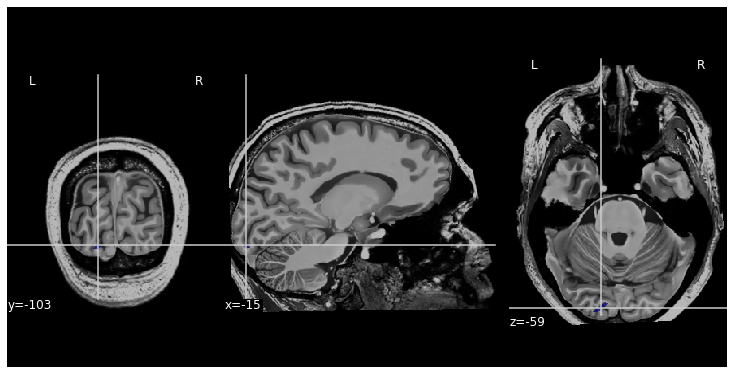

In [11]:
fig = plt.figure(figsize=(10,5))
# g = fig.add_subplot(111)

p = plot_roi(beam, bg_img=anat, cut_coords=tuple(coord), figure=fig)